In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, accuracy_score)
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

print(f'Rows: {df.shape[0]}')
print(f'Columns: {df.shape[1]}')

df.head()

Rows: 7043
Columns: 21


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
print(df.dtypes)
print()
print(df.isnull().sum())

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
M

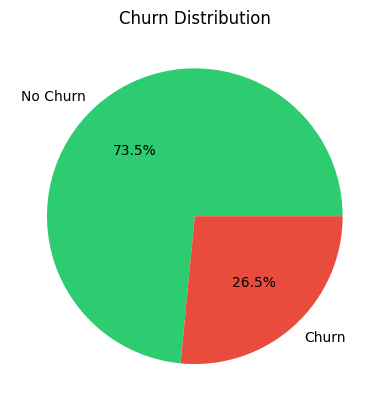

In [6]:
df['Churn'].value_counts().plot(kind='pie', autopct='%1.1f%%',
                                colors=['#2ecc71', '#e74c3c'],
                                labels=['No Churn', 'Churn'])
plt.title('Churn Distribution')
plt.ylabel('')
plt.show()

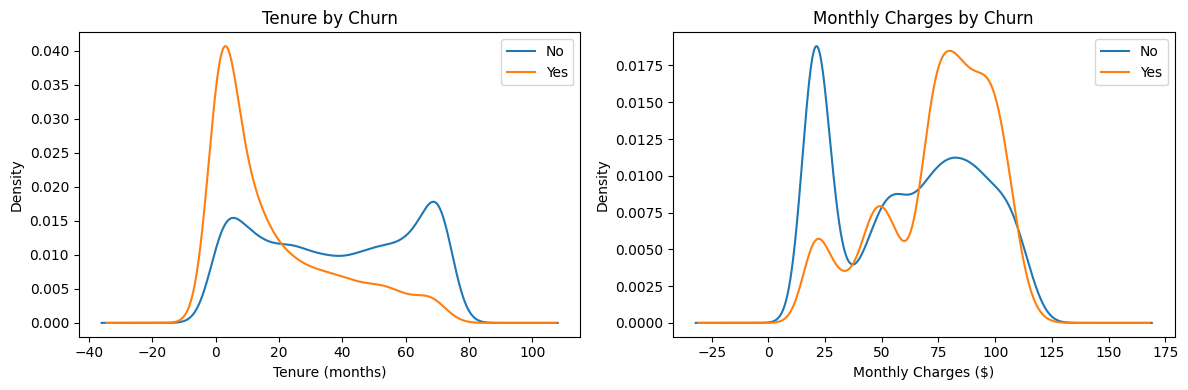

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df.groupby('Churn')['tenure'].plot(kind='kde', ax=axes[0], legend=True)
axes[0].set_title('Tenure by Churn')
axes[0].set_xlabel('Tenure (months)')

df.groupby('Churn')['MonthlyCharges'].plot(kind='kde', ax=axes[1], legend=True)
axes[1].set_title('Monthly Charges by Churn')
axes[1].set_xlabel('Monthly Charges ($)')

plt.tight_layout()
plt.show()

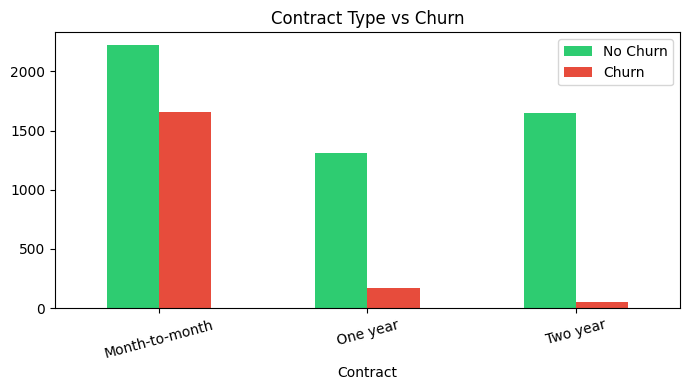

In [8]:
contract_churn = df.groupby(['Contract', 'Churn']).size().unstack()
contract_churn.plot(kind='bar', color=['#2ecc71', '#e74c3c'], figsize=(7, 4))
plt.title('Contract Type vs Churn')
plt.xticks(rotation=15)
plt.legend(['No Churn', 'Churn'])
plt.tight_layout()
plt.show()

In [9]:
# Drop customerID — not useful
df.drop('customerID', axis=1, inplace=True)

# TotalCharges is stored as text, convert to number
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing values with median
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

print('Missing values remaining:', df.isnull().sum().sum())

Missing values remaining: 0


In [10]:
# Convert target: Yes → 1, No → 0
df['Churn'] = (df['Churn'] == 'Yes').astype(int)

# Find all text columns
cat_cols = df.select_dtypes(include='object').columns.tolist()
print('Columns to encode:', cat_cols)

# Encode each column
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

df.head(3)

Columns to encode: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1


In [11]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X = X.fillna(X.median())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print(f'Train: {X_train.shape[0]} samples')
print(f'Test : {X_test.shape[0]} samples')

Train: 5634 samples
Test : 1409 samples


In [12]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

lr_pred = lr_model.predict(X_test_scaled)
lr_prob = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f'Accuracy : {accuracy_score(y_test, lr_pred):.4f}')
print(f'ROC-AUC  : {roc_auc_score(y_test, lr_prob):.4f}')

Accuracy : 0.7991
ROC-AUC  : 0.8403


In [13]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]

print(f'Accuracy : {accuracy_score(y_test, rf_pred):.4f}')
print(f'ROC-AUC  : {roc_auc_score(y_test, rf_prob):.4f}')

Accuracy : 0.7921
ROC-AUC  : 0.8225


In [14]:
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

gb_pred = gb_model.predict(X_test)
gb_prob = gb_model.predict_proba(X_test)[:, 1]

print(f'Accuracy : {accuracy_score(y_test, gb_pred):.4f}')
print(f'ROC-AUC  : {roc_auc_score(y_test, gb_prob):.4f}')

Accuracy : 0.8013
ROC-AUC  : 0.8449


In [15]:
for name, pred in [('Logistic Regression', lr_pred),
                   ('Random Forest', rf_pred),
                   ('Gradient Boosting', gb_pred)]:
    print(f'\n{"="*45}')
    print(f' {name}')
    print(f'{"="*45}')
    print(classification_report(y_test, pred, target_names=['No Churn', 'Churn']))


 Logistic Regression
              precision    recall  f1-score   support

    No Churn       0.84      0.89      0.87      1035
       Churn       0.64      0.55      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409


 Random Forest
              precision    recall  f1-score   support

    No Churn       0.83      0.90      0.86      1035
       Churn       0.64      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409


 Gradient Boosting
              precision    recall  f1-score   support

    No Churn       0.84      0.91      0.87      1035
       Churn       0.67      0.51      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg    

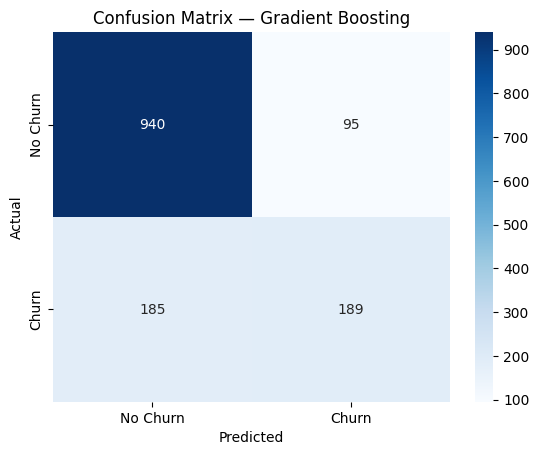

In [16]:
cm = confusion_matrix(y_test, gb_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix — Gradient Boosting')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

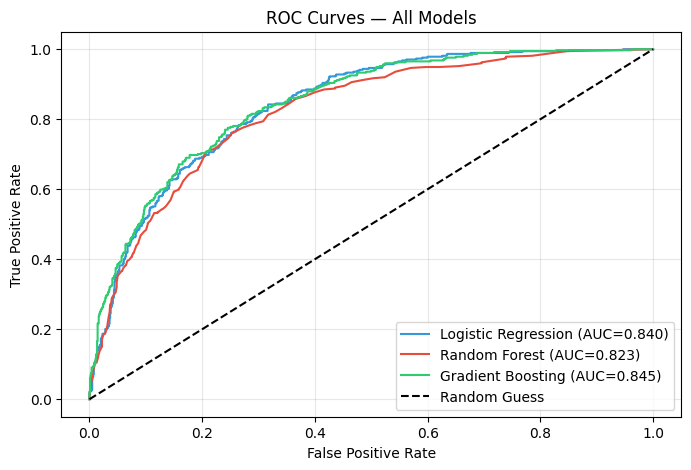

In [17]:
plt.figure(figsize=(8, 5))

for name, prob, color in [
    ('Logistic Regression', lr_prob, '#3498db'),
    ('Random Forest',       rf_prob, '#e74c3c'),
    ('Gradient Boosting',   gb_prob, '#2ecc71'),
]:
    fpr, tpr, _ = roc_curve(y_test, prob)
    auc = roc_auc_score(y_test, prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', color=color)

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves — All Models')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

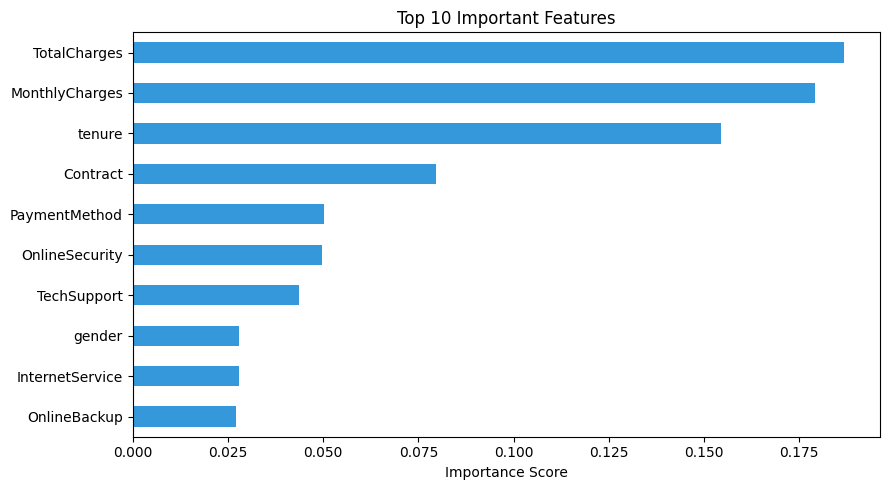

,Model,Accuracy,ROC-AUC
0,Gradient Boosting,0.801278,0.844869
1,Logistic Regression,0.799148,0.840280
2,Random Forest,0.792051,0.822504


In [18]:
# Feature Importance
feat_imp = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_imp.sort_values().tail(10).plot(kind='barh', color='#3498db', figsize=(9, 5))
plt.title('Top 10 Important Features')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Summary Table
summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [accuracy_score(y_test, lr_pred),
                 accuracy_score(y_test, rf_pred),
                 accuracy_score(y_test, gb_pred)],
    'ROC-AUC': [roc_auc_score(y_test, lr_prob),
                roc_auc_score(y_test, rf_prob),
                roc_auc_score(y_test, gb_prob)]
})

summary.sort_values('ROC-AUC', ascending=False, ignore_index=True)